# Investigate a Dataset: Titanic Data

## 1. Introduction

In this report, I will investigate the Titanic survivor data using exploratory data analysis.

In the data wrangling phase, I will determine the appropriate datatypes for our dataset, and I will also show how to handle missing values. 

In the data exploration phase, I will first look at each variable and its distribution. After that, I will answer two question:

1. What factors make people more likely to survive?

2. What money can buy? -- Explore relations among passenger class, cabin, and fare. 

Last, I will conclude this report by summarizing the findings and stating the limitations of my analysis.

# 2 Data Wrangling

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 2.1 Handling Data Types

After reviewing the original description of the dataset from [the Kaggle website](https://www.kaggle.com/c/titanic/data), the data type of each variable is chosen as following, and categorical variables will be converted to more descriptive labels:

| Variable | Definition                                 | Key                                            | Type            |
|----------|--------------------------------------------|------------------------------------------------|-----------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                | int (Survived)* |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | int (Class)     |
| Sex      | Sex                                        |                                                | str             |
| Age      | Age in years                               |                                                | float           |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                | int             |
| ParCh    | # of parents / children aboard the Titanic |                                                | int             |
| Ticket   | Ticket number                              |                                                | int             |
| Fare     | Passenger fare                             |                                                | float           |
| Cabin    | Cabin number                               |                                                | str             |
| Embarked | Port of embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | str (Port)      |

\* indicate the name of converted categorical variable

In [4]:
data_file = 'titanic-data.csv'
titanic_df = pd.read_csv(
    data_file, 
    dtype = {'PassengerId': str}
)

In [6]:
# Convert categorical variables to more descriptive labels.

# Create descriptive Survival column from Survived column
titanic_df['Survival'] = titanic_df['Survived'].map({0: 'Died', 
                                                     1: 'Survived'})

# Create descriptive Class column from Pclass column 
titanic_df['Class'] = titanic_df['Pclass'].map({1: 'First Class', 
                                                2: 'Second Class', 
                                                3: 'Third Class'})

# Create descriptive Port column from Embarked column
titanic_df['Port'] = titanic_df['Embarked'].map({'C': 'Cherbourg', 
                                                 'Q': 'Queenstown', 
                                                 'S': 'Southampton'})

### 2.2 Handling Missing Values

In [12]:
total_passengers = len(titanic_df)
print("There are {} passengers on board.".format(total_passengers))

There are 891 passengers on board.


In [13]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
ParCh            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survival         0
Class            0
Port             2
dtype: int64

There are three columns with missing values: Age, Cabin, and Embarked(Port).

#### 2.2.1 Age

There are 117 out of 891 passengers missing Age values. Because filling in the missing Age values will affect the distribution of Age variable, and this analysis is mainly exploratory, I will **drop rows with missing Age values**.

But as an exercise, I will show here a way of filling in the missing Age values based on the assumption that Age values can be infered from SibSp, ParCh, Class, and Sex.

We'll store the filled Age values in a new column called AgeFilled.

In [18]:
titanic_df['AgeFilled'] = titanic_df['Age']

##### SibSp and ParCh

SibSp(number of siblings/spouses): The number of spouses can only be 0 or 1, therefore any SibSp value greater than 1 can be implied that this person is traveling with sibling(s).

ParCh(number of parents/children): The number of parents can only be 2 maximum, any ParCh value greater than 2 can be implied that this person is traveling with child(ren).

From these two observations, we can infer two rules:

1. If SibSp >= 2, this passenger has at least 1 sibling on board, and if also his/her ParCh >= 1, then he/she is most likly a **child** traveling with sibling(s) and parent(s).

2. If Parch >= 3, this passenger has at least 1 child, then he/she has to be an **adult** parent traveling with child(ren).

From these two rules, we can divide all rows into three categories: **Child**, **Adult**, **Unknown**, and store this categorical value in a new column ChAd. And we can fill in the Age value of the row categoried with child or parent with its category's median age value.

In [14]:
def child_or_adult(sibsp, parch):
    '''Categorize a person as Child, Adult or Unknown
    
    Arg:
    sibsp: the number of siblings/spouses
    parch: the number of parents/children
    
    Return:
    A string denotes Child, Adult or Unknown
    '''
    if sibsp >= 2 and parch >= 1:
        return 'Child'
    if parch >= 3:
        return 'Adult'
    return 'Unknown'

In [17]:
titanic_df['ChAd'] = titanic_df[['SibSp', 'ParCh']].apply(lambda x: child_or_adult(*x), axis=1)

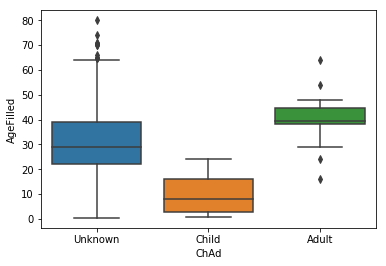

In [22]:
sns.boxplot(x='ChAd', y='AgeFilled', data=titanic_df)

Fill Adult, Child groups' missing Age values with groups' median values. Leave Unknown group' missing Age values as NaN.

In [23]:
for group_name, group in titanic_df.groupby('ChAd'):
    if group_name == 'Adult' or group_name == 'Child':
        group['AgeFilled'].fillna(group['AgeFilled'].median())

##### Class and Sex

For the passengers categorized as Unknown in the ChAd column, I will fill the missing Age values with the median value of the same Class and Sex group.

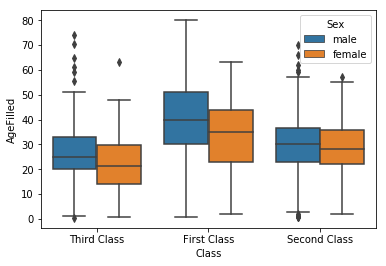

In [26]:
sns.boxplot(x='Class', y='AgeFilled', hue='Sex', data=titanic_df)

In [28]:
fillna_with_median = lambda x: x.fillna(x.median(), inplace=False)
titanic_df['AgeFilled'] = titanic_df.groupby(['Sex', 'Pclass'])['AgeFilled'].transform(fillna_with_median)

I will look at how the distribution of Age has changed after filling the missing values in the next section.

#### 2.2.2 Cabin

There are 689 out of 891 passengers missing Cabin values. Because the majority of rows are missing cabin values, I decide to exclude these rows during analysis when cabin value is considered.

#### 2.2.3 Embarked (Port)

There are 2 out of 891 passengers missing Embarked values. Here I choose to fill these two missing values with the most frequent value (mode).

In [29]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode().iloc[0]);
titanic_df['Port'] = titanic_df['Port'].fillna(titanic_df['Port'].mode().iloc[0]);